---

_You are currently looking at **version 1.0** of this notebook. To download notebooks and datafiles, as well as get help on Jupyter notebooks in the Coursera platform, visit the Jupyter Notebook FAQ course resource._

---

# Predicting viewer engagement in educational videos

## Context

*Goal: predict viewer engagement in educational videos.

*Dataset: Educational video features from the VLE Dataset https://github.com/sahanbull/VLE-Dataset 

*Data fields in train.csv & test.csv:

-title_word_count - the number of words in the title of the video.

-document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.

-freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.

-easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.

-fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.

-speaker_speed - The average speaking rate in words per minute of the presenter in the video.

-silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).

*Data field in train.csv only:

-engagement - Target label for training. True if learners watched a substantial portion of the video (at least 30%), or False otherwise.

## Data load and preview

In [19]:
# Import all required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

np.random.seed(0) 

In [20]:
df_train = pd.read_csv('./train.csv')
print(df_train.shape)
df_train.head()

(9239, 10)


,id,title_word_count,document_entropy,freshness,easiness,fraction_stopword_presence,normalization_rate,speaker_speed,silent_period_rate,engagement
0,1,9,7.753995,16310,75.583936,0.553664,0.034049,2.997753,0.0,True
1,2,6,8.305269,15410,86.870523,0.584498,0.018763,2.635789,0.0,False
2,3,3,7.965583,15680,81.915968,0.605685,0.030720,2.538095,0.0,False
3,4,9,8.142877,15610,80.148937,0.593664,0.016873,2.259055,0.0,False
4,5,9,8.161250,14920,76.907549,0.581637,0.023412,2.420000,0.0,False


## Exploratory analysis

### Data distribution

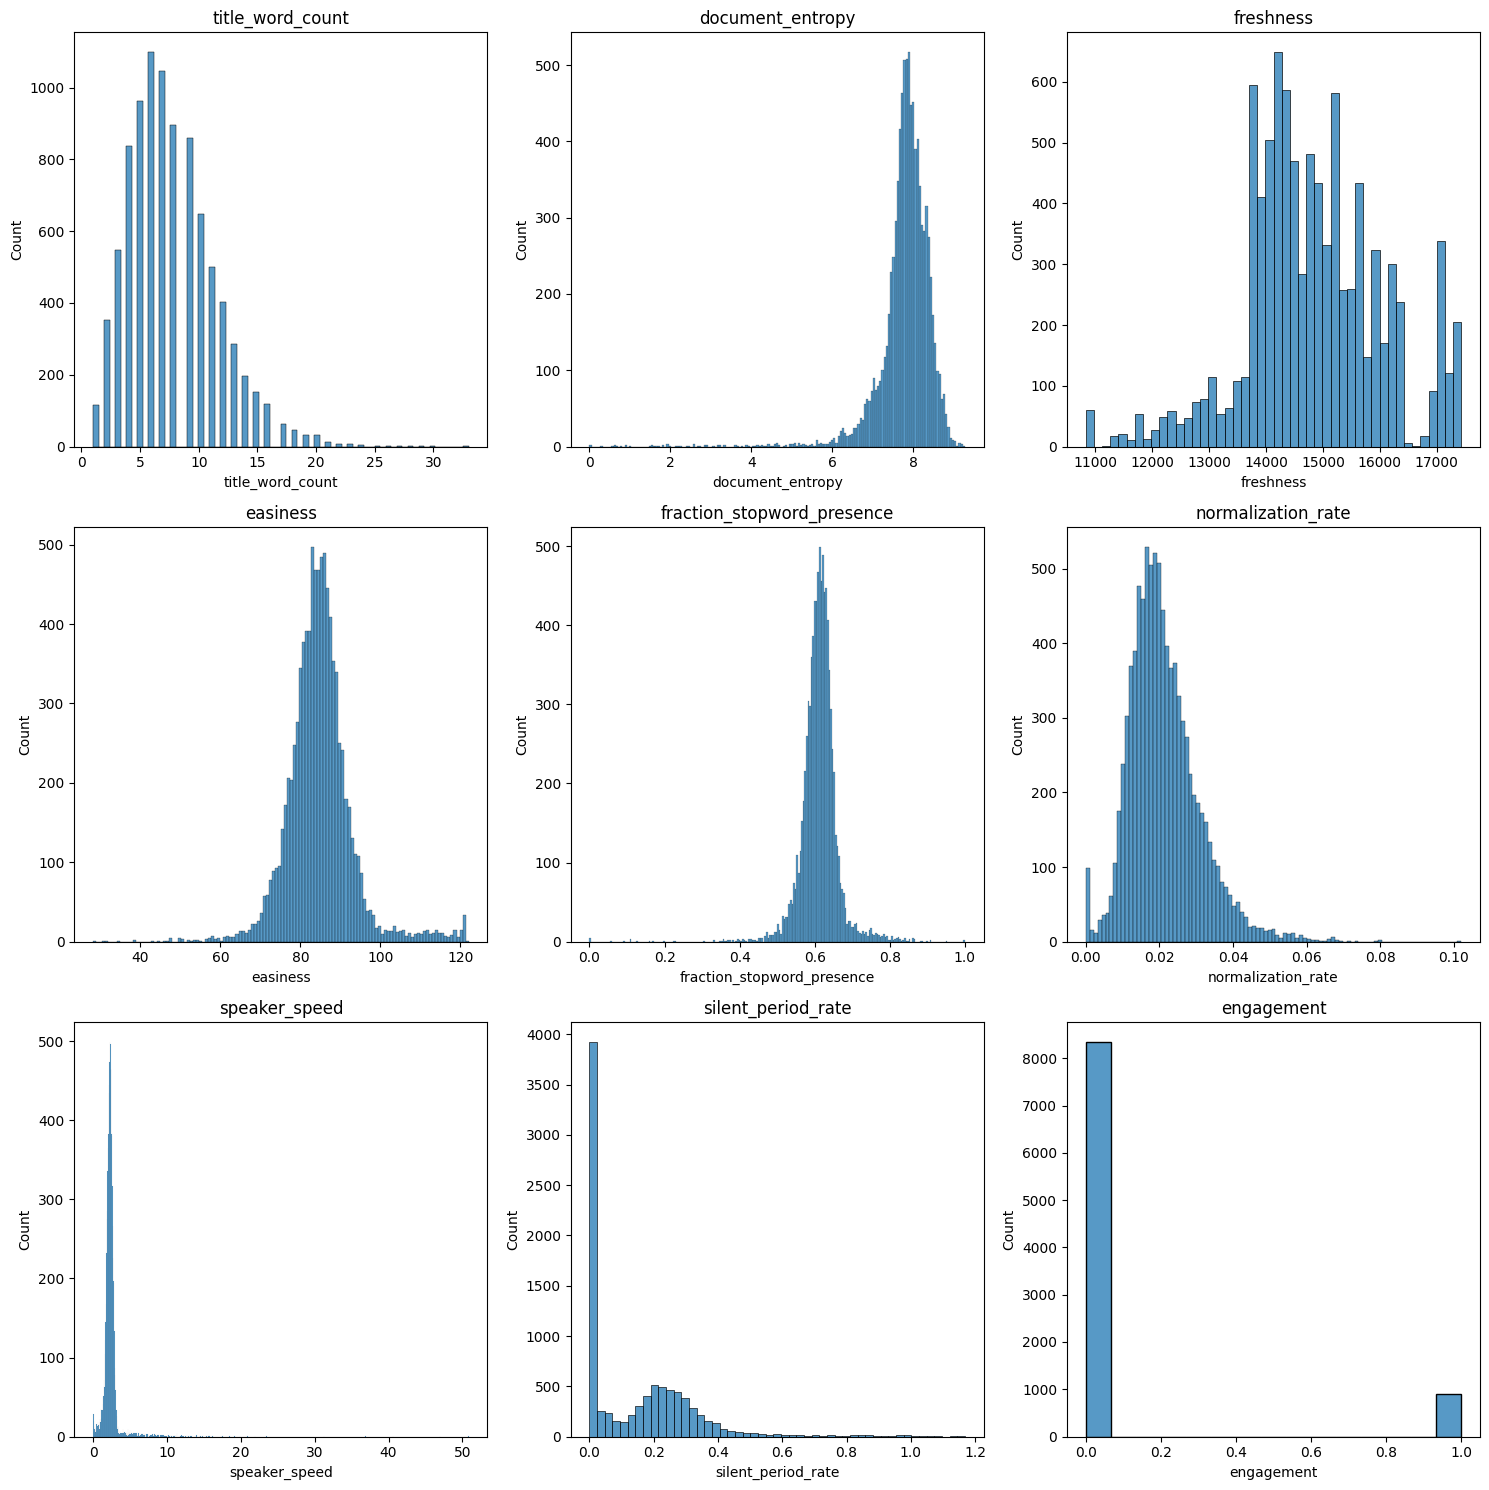

In [21]:
fig, subaxes = plt.subplots(int(len(df_train.columns[1:-1])/3) + 1 , 3, figsize=(15, 15))
ii = 1
for row in subaxes:
    for this_axis in row:
        sns.histplot(df_train.iloc[:, ii], ax=this_axis)
        this_axis.set_title('{}'.format(df_train.columns[ii]))
        ii = ii + 1
plt.tight_layout()
plt.show()

Data distribution can help us understand some patterns of the dataset. For instance, we can see most of the videos have a short title with 3 to 6 words being the most frequent.
We can also see the variable "Document_entropy" shows mainly high values, meaning the videos in the dataset are not very cohesive and focused on multiple topics.
Finally, the silent period rate is mainly at 0%, meaning the fraction of time in the lecture videos without speaking is practically null.

### Data correlation

We can see the target variable "Engagement" is negatively correlated with the rest of variables, except for "Freshness" and "Normalization rate". 
Also, there is a quite significant correlation between "Easiness" and "Noramlization rate",  between "Freshess" and "Silent period rate", and "Document entropy" vs "Easiness". 

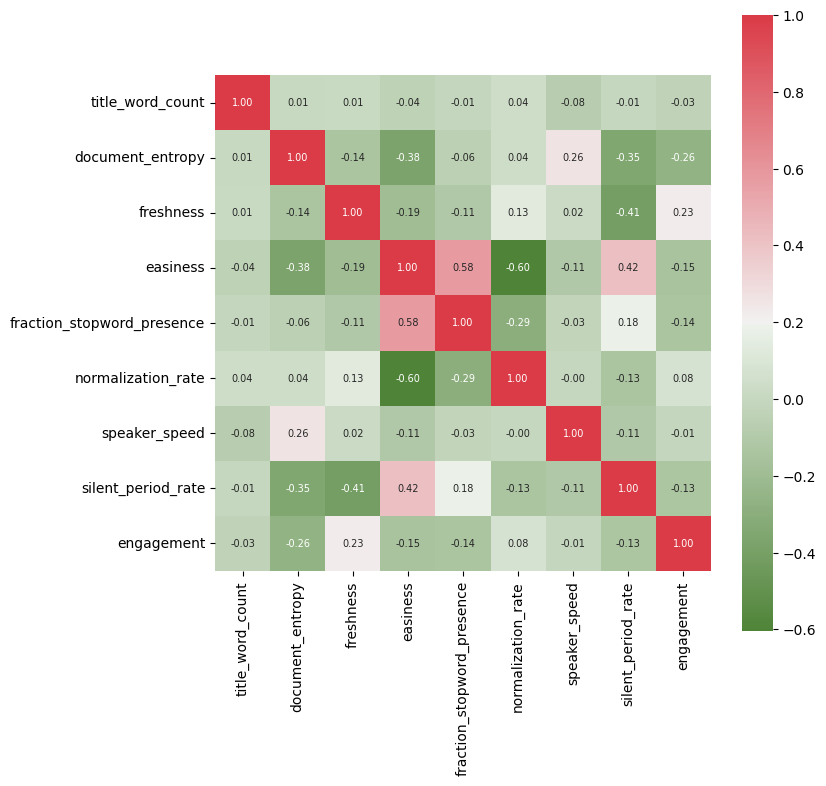

In [22]:
df_corr = df_train.iloc[:,1:].corr()
plt.figure(figsize=(8,8))
sns.heatmap(df_corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 7},
           xticklabels= df_corr.columns, 
           yticklabels= df_corr.columns,
           cmap=sns.diverging_palette(120, 10, as_cmap=True))
plt.show()

### Features Importance

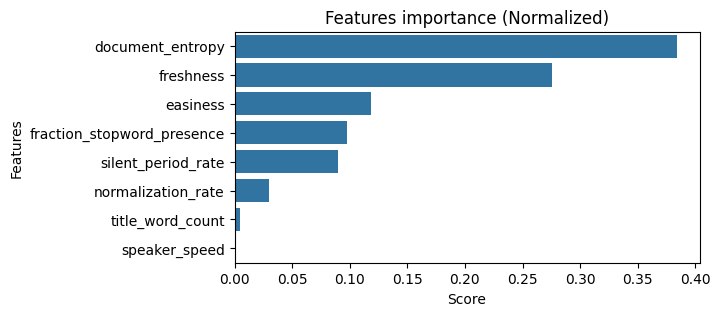

In [23]:
from sklearn.feature_selection import SelectKBest, f_classif

# Setting X as training dataset and Y as test dataset
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1]

this_k = 8
selector = SelectKBest(f_classif, k='all')
selector.fit(X, y)

# get the score for each feature
scores = selector.scores_

feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': scores})
total = feature_scores['Score'].sum()
feature_scores['Score'] = feature_scores['Score']/total
feature_scores.sort_values('Score', ascending=False, inplace=True)

plt.figure(figsize=(6,3))
sns.barplot(x='Score', y='Feature', data=feature_scores)
plt.xlabel('Score')
plt.ylabel('Features')
plt.title('Features importance (Normalized)')
# plt.xticks(rotation=20, ha='right')
plt.show()

Looking at the scores for each feature in the training dataset, we can see the most important features are:
1. document_entropy - a score indicating how varied the topics are covered in the video, based on the transcript. Videos with smaller entropy scores will tend to be more cohesive and more focused on a single topic.

2. freshness - The number of days elapsed between 01/01/1970 and the lecture published date. Videos that are more recent will have higher freshness values.

3. easiness - A text difficulty measure applied to the transcript. A lower score indicates more complex language used by the presenter.

4. fraction_stopword_presence - A stopword is a very common word like 'the' or 'and'. This feature computes the fraction of all words that are stopwords in the video lecture transcript.

5. silent_period_rate - The fraction of time in the lecture video that is silence (no speaking).

This means the machine learning model to predict engangement could take into account only these 5 features:

In [24]:
features = ['document_entropy', 'freshness', 'easiness',
            'fraction_stopword_presence', 'silent_period_rate']
X = df_train[features]
y = df_train.iloc[:, -1]
y = y.astype(int)
X.head()

,document_entropy,freshness,easiness,fraction_stopword_presence,silent_period_rate
0,7.753995,16310,75.583936,0.553664,0.0
1,8.305269,15410,86.870523,0.584498,0.0
2,7.965583,15680,81.915968,0.605685,0.0
3,8.142877,15610,80.148937,0.593664,0.0
4,8.161250,14920,76.907549,0.581637,0.0


### Basic statistics

In [25]:
X.describe()

,document_entropy,freshness,easiness,fraction_stopword_presence,silent_period_rate
count,9239.000000,9239.000000,9239.000000,9239.000000,9239.000000
mean,7.792685,14808.587509,84.756029,0.612214,0.146606
std,0.697710,1208.953646,8.303489,0.051872,0.172030
min,0.000000,10830.000000,28.210966,0.000000,0.000000
25%,7.594235,14070.000000,80.415060,0.589632,0.000000
50%,7.875103,14750.000000,84.482122,0.613127,0.104915
75%,8.164166,15600.000000,88.388711,0.634585,0.250927
max,9.278573,17430.000000,122.032000,1.000000,1.168239


We check the scatter distribution for the first 2 most important features for later ML models

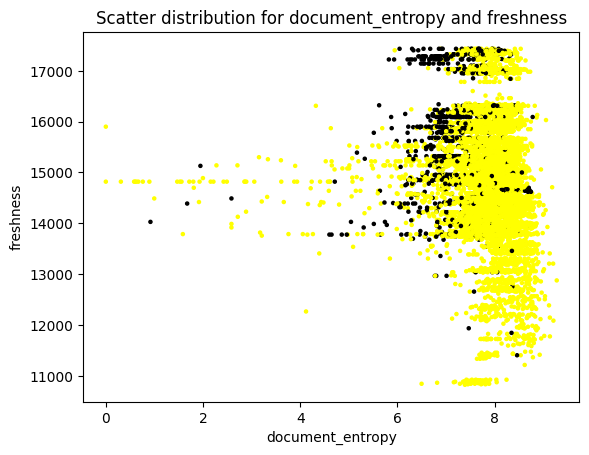

In [26]:
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FFFF00', '#00FF00', '#0000FF','#000000'])

plt.figure()
plt.scatter(X.iloc[:, 0].values, X.iloc[:, 1].values, marker= 'o', c=y, s=5, cmap=cmap_bold)
plt.title('Scatter distribution for {} and {}'.format(X.columns[0], X.columns[1]))
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])
plt.show()

## Supervised Machine Learning Models

To predict viewer engagement in educational videos, we develop 3 different supervised ML models for classification: Naive Bayes, Random Forest and Gradient-boosted decision tree:

### Naive Bayes classifier

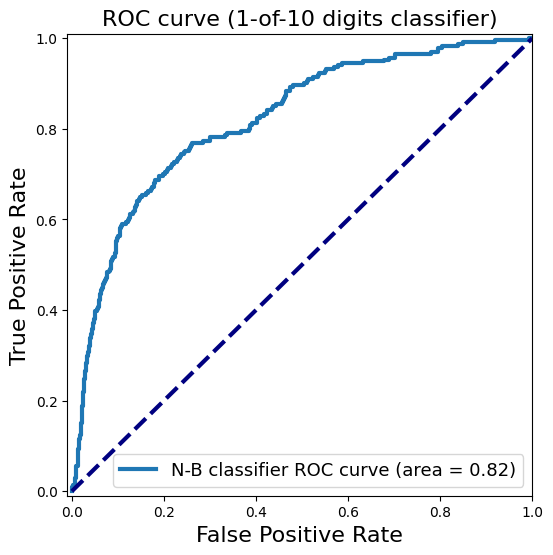

In [27]:
# training a Naive Bayes Classifier using all data
from sklearn.naive_bayes import GaussianNB
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

nbclf = GaussianNB().fit(X_train, y_train)
y_probabilities = nbclf.predict_proba(X_test)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probabilities[:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='N-B classifier ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

### Random forest

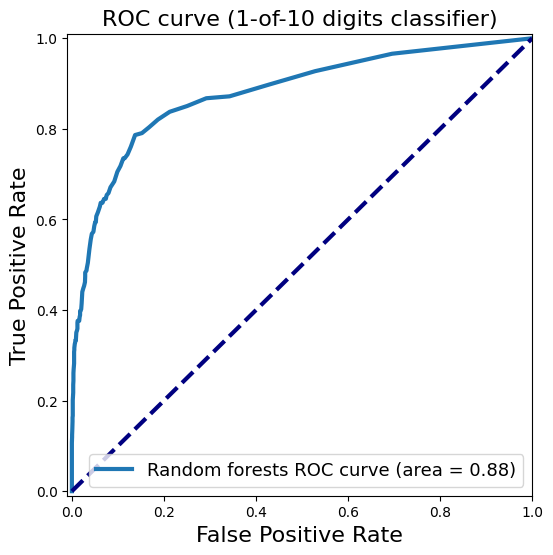

In [28]:
# training a Random Forest using all data
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

rfclf = RandomForestClassifier().fit(X_train, y_train)
y_probabilities = rfclf.predict_proba(X_test)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_probabilities[:,1])
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='Random forests ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

### Gradient-boosted decision tree

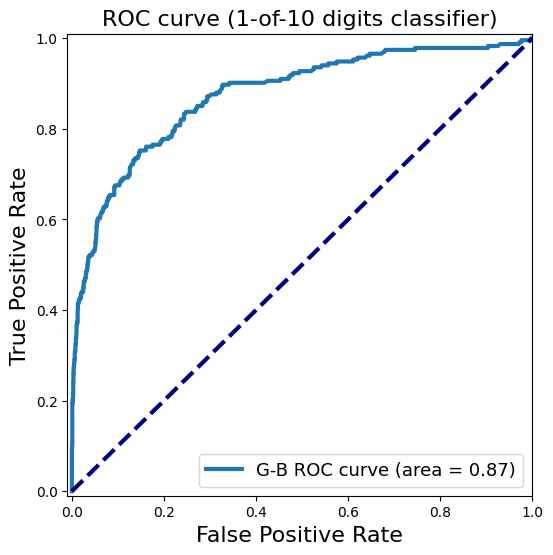

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

gbclf = GradientBoostingClassifier().fit(X_train, y_train)
y_decision = gbclf.decision_function(X_test)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_decision)
roc_auc_lr = auc(fpr_lr, tpr_lr)

plt.figure(figsize=(6,6))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_lr, tpr_lr, lw=3, label='G-B ROC curve (area = {:0.2f})'.format(roc_auc_lr))
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve (1-of-10 digits classifier)', fontsize=16)
plt.legend(loc='lower right', fontsize=13)
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.show()

## Best Performance

We check what parameter values would result in model optimization for each case and compare performance

### Naive Bayes Classifier

In [30]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

param_grid = {'var_smoothing': [1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

gnb = GaussianNB()

grid_search = GridSearchCV(gnb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
grid_search.fit(X_train, y_train)

grid_search.best_score_

0.836523983801236

### Random Forest Classifier

In [31]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rfc = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
0.886031362437366


Therefore, we can achieve a higher performace by using a Random Forest Classifier model optimized with the following hyperparameters:
1. 'max_depth': 10
2. 'max_features': 'sqrt'
3. 'min_samples_leaf': 4
4. 'min_samples_split': 10
5. 'n_estimators': 200

## Final Model

If we use only the most important features and apply the Random Forest Classifier with optimized hyperparamethers, we'll achieve the best performer model.

In [32]:
from sklearn.ensemble import RandomForestClassifier

df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

most_important_features = ['document_entropy', 'freshness', 'easiness',
                   'fraction_stopword_presence', 'silent_period_rate']

X_train, y_train = df_train[most_important_features], df_train.iloc[:,-1].astype(int)
X_test = df_test[most_important_features]
rfc = RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=4, 
                             min_samples_split=10, n_estimators=200, n_jobs=-1,
                             random_state=0)
rfc.fit(X_train, y_train)

y_pred = rfc.predict_proba(X_test)
y_pred.shape

(2309, 2)

Preview of the predicted values

In [33]:
indexes = df_test['id'].values
probabilities = y_pred[:,1]

result = pd.Series(probabilities, index=indexes)
result.head()

9240    0.016028
9241    0.056213
9242    0.071576
9243    0.867116
9244    0.024955
dtype: float64